# TCN training + neutone export

This Colab notebook is based on the [steerable discovery of neural audio effects paper](https://arxiv.org/abs/2112.02926) by Christian Steinmetz and Joshua Reiss and its accompanying [Colab notebook](https://colab.research.google.com/github/csteinmetz1/steerable-nafx/blob/master/steerable-nafx.ipynb).

By Naotake Masuda @ Qosmo (most of TCN code by Christopher Mitcheltree from neutone_sdk)

With this notebook you can...
- Roughly emulate a simple audio effect from the dry/wet signal data
- Find unique controls for the effect
- Use the effect in neutone VST!

In [ ]:
!pip install auraloss neutone_sdk

In [ ]:
#@title Import necessary Libraries
import IPython
from google.colab import files
from tqdm.notebook import tqdm
import numpy as np
import scipy.signal
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Image
import pathlib, os
from typing import Dict, List, Optional

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torchaudio
import auraloss

from neutone_sdk import WaveformToWaveformBase, NeutoneParameter
from neutone_sdk.utils import save_neutone_model

In [ ]:
#@title Define TCN Model
class Conv1dCausal(nn.Module):  # Conv1d with cache
    """Causal convolution (padding applied to only left side)"""
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 dilation: int = 1,
                 bias: bool = True) -> None:
        super().__init__()
        self.padding = (kernel_size - 1) * dilation # input_len == output_len when stride=1
        self.in_channels = in_channels
        self.conv = nn.Conv1d(in_channels,
                              out_channels,
                              (kernel_size,),
                              (stride,),
                              padding=0,
                              dilation=(dilation,),
                              bias=bias)

    def forward(self, x: Tensor) -> Tensor:
        x = F.pad(x, (self.padding, 0)) # standard zero padding
        x = self.conv(x)
        return x

class FiLM(nn.Module):
    def __init__(self,
                 cond_dim: int,  # dim of conditioning input
                 num_features: int,  # dim of the conv channel
                ) -> None:
        super().__init__()
        self.num_features = num_features
        self.adaptor = nn.Linear(cond_dim, 2 * num_features)

    def forward(self, x: Tensor, cond: Tensor) -> Tensor:
        cond = self.adaptor(cond)
        g, b = torch.chunk(cond, 2, dim=-1)
        g = g.unsqueeze(-1)
        b = b.unsqueeze(-1)
        x = (x * g) + b  # Then apply conditional affine
        return x

class TCNBlock(nn.Module):
    def __init__(self,
                 in_ch: int,
                 out_ch: int,
                 kernel_size: int = 3,
                 dilation: int = 1,
                 stride: int = 1,
                 cond_dim: int = 0) -> None:
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
        self.cond_dim = cond_dim
        self.act = nn.PReLU()
        self.conv = Conv1dCausal(
            in_ch,
            out_ch,
            kernel_size,
            stride=stride,
            dilation=dilation,
            bias=True,
        )
        self.res = nn.Conv1d(in_ch, out_ch, kernel_size=(1,), bias=False)
        assert cond_dim > 0
        self.film = FiLM(cond_dim, out_ch)

    def forward(self, x: Tensor, cond: Tensor) -> Tensor:
        assert x.ndim == 3  # (batch_size, in_ch, samples)
        x_in = x
        x = self.conv(x)
        x = self.film(x, cond)
        x = self.act(x)
        x_res = self.res(x_in)
        x += x_res
        return x


class TCN(nn.Module):
    def __init__(self,
                 channels: List[int],
                 dilations: List[int],
                 in_ch: int = 1,
                 out_ch: int = 1,
                 kernel_size: int = 13,
                 cond_dim: int = 0) -> None:
        super().__init__()
        self.channels = channels # intermediate channels
        self.in_ch = in_ch # input channels
        self.out_ch = out_ch # output channels
        self.kernel_size = kernel_size
        self.cond_dim = cond_dim
        self.out_net = nn.Conv1d(channels[-1], out_ch, kernel_size=(1,), stride=(1,), bias=False)
        # self.out_net = Conv1dCausal(channels[-1], out_ch, 5, 1, 1, bias=False)
        self.n_blocks = len(channels)
        assert len(dilations) == self.n_blocks
        self.dilations = dilations
        # only supports stride=1 for now
        strides = [1] * self.n_blocks
        self.strides = strides

        self.blocks = nn.ModuleList()
        block_out_ch = None
        for idx, (curr_out_ch, dil, stride) in enumerate(zip(channels, dilations, strides)):
            if idx == 0:
                block_in_ch = in_ch
            else:
                block_in_ch = block_out_ch
            block_out_ch = curr_out_ch

            self.blocks.append(TCNBlock(
                block_in_ch,
                block_out_ch,
                kernel_size,
                dil,
                stride,
                cond_dim,
            ))

    def forward(self, x: Tensor, cond: Tensor) -> Tensor:
        assert x.ndim == 3  # (batch_size, in_ch, samples)
        assert cond.shape == (x.size(0), self.cond_dim)  # (batch_size, cond_dim)
        for block in self.blocks:
            x = block(x, cond)
        x = self.out_net(x)
        return x

    def calc_receptive_field(self) -> int:
        """Compute the receptive field in samples."""
        assert all(_ == 1 for _ in self.strides)  # TODO(cm): add support for dsTCN
        assert self.dilations[0] == 1  # TODO(cm): add support for >1 starting dilation
        rf = self.kernel_size
        for dil in self.dilations[1:]:
            rf = rf + ((self.kernel_size - 1) * dil)
        return rf

In [ ]:
#@title Upload clean sound (x)
# upload the clean input file
input_upload = files.upload()
input_file = list(input_upload.keys())[-1]
x, sample_rate = torchaudio.load(input_file)
print(input_file, x.shape)
IPython.display.display(IPython.display.Audio(data=x, rate=sample_rate))

In [ ]:
# upload the same file processed with an effect
#@title Upload processed sound (y)
output_upload = files.upload()
output_file = list(output_upload.keys())[-1]
y, sample_rate = torchaudio.load(output_file)
print(output_file, y.shape)
IPython.display.display(IPython.display.Audio(data=y, rate=sample_rate))

# reshape the audio
if not y.shape[-1] == x.shape[-1]:
    print(f"Input and output files are different lengths! Found clean: {x.shape[-1]} processed: {y.shape[-1]}.")
    if y.shape[-1] > x.shape[-1]:
        print(f"Cropping target...")
        y = y[:,:x.shape[-1]]
    else:
        print(f"Cropping input...")
        x = x[:,:y.shape[-1]]
# make audio mono (use left channel) (batch, channel, time)
proc_x = x[None, 0:1, :]
proc_y = y[None, 0:1, :]

In [ ]:
#@title TCN model training parameters
from torchvision.transforms import RandomCrop
cond_dim = 3
n_iters = 2458 #@param {type:"slider", min:0, max:10000, step:1}
lr = 0.002 #@param {type:"number"}
slice_len = 240000 #@param {type:"number"}
dilation_growth = 8 #@param {type:"number"}
n_layers = 5 #@param {type:"number"}
n_channels = 8 #@param {type:"number"}
crop = RandomCrop((slice_len,1)) # randomly crop audio
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

slice_len = min(x.shape[-1], slice_len)

c = torch.zeros(1, cond_dim, device=device, requires_grad=False)
_, x_ch, x_samp = proc_x.shape
_, y_ch, y_samp = proc_y.shape
# build the model
model = TCN(channels=[n_channels] * n_layers,
            cond_dim=cond_dim,
            dilations=[dilation_growth ** idx for idx in range(n_layers)]
            )

rf = model.calc_receptive_field()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameters: {params*1e-3:0.3f} k")

# setup loss function, optimizer, and scheduler
loss_fn = auraloss.freq.MultiResolutionSTFTLoss(
    fft_sizes=[32, 128, 512, 2048],
    win_lengths=[32, 128, 512, 2048],
    hop_sizes=[16, 64, 256, 1024])
loss_fn_l1 = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr)
ms1 = int(n_iters * 0.8)
ms2 = int(n_iters * 0.95)
milestones = [ms1, ms2]

print(
    "Learning rate schedule:",
    f"1:{lr:0.2e} ->",
    f"{ms1}:{lr*0.1:0.2e} ->",
    f"{ms2}:{lr*0.01:0.2e}",
)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones,
    gamma=0.1,
    verbose=False,
)

# move tensors to GPU
if torch.cuda.is_available():
    model = model.to(device)
    proc_x = proc_x.to(device)
    proc_y = proc_y.to(device)
    c = c.to(device)

# iteratively update the weights
pbar = tqdm(range(n_iters))
losses = []
for n in pbar:
    optimizer.zero_grad()
    # crop both input/output randomly
    start_idx = torch.randint(0, proc_x.shape[-1]-slice_len, (1,))[0]
    x_crop = proc_x[..., start_idx:start_idx+slice_len]
    y_crop = proc_y[..., start_idx:start_idx+slice_len]
    y_hat = model(x_crop, c)
    # crop output bc first rf samples don't have proper context
    loss = loss_fn(y_hat[..., rf:], y_crop[..., rf:])
    loss.backward()
    losses.append(loss.detach().cpu())
    optimizer.step()
    scheduler.step()
    if (n+1) % 1 == 0:
        pbar.set_description(f" Loss: {loss.item():0.3e} | ")
plt.title("Training loss over iterations")
plt.plot(losses)

In [ ]:
#@title Listen to results
with torch.no_grad():
    out = model(proc_x.to(device), c)
print("Input (dry)")
IPython.display.display(IPython.display.Audio(data=proc_x[0].detach().cpu(), rate=sample_rate))
print("Target")
IPython.display.display(IPython.display.Audio(data=proc_y[0].detach().cpu(), rate=sample_rate))
print("Network Output")
IPython.display.display(IPython.display.Audio(data=out[0].detach().cpu(), rate=sample_rate))
fig, axes = plt.subplots(3, 2, figsize=(10, 10), squeeze=False)
axes[0,0].specgram(proc_x[0,0].detach().cpu().numpy(), Fs=sample_rate, scale='dB')
axes[1,0].specgram(proc_y[0,0].detach().cpu().numpy(), Fs=sample_rate, scale='dB')
axes[2,0].specgram(out[0,0].detach().cpu().numpy(), Fs=sample_rate, scale='dB')
axes[0,1].plot(proc_x[0,0].detach().cpu().numpy())
axes[0,1].set_ylim(-1,1)
axes[1,1].plot(proc_y[0,0].detach().cpu().numpy())
axes[1,1].set_ylim(-1,1)
axes[2,1].plot(out[0,0].detach().cpu().numpy())
axes[2,1].set_ylim(-1,1)

- Some artifacts can be present, especially at the after initialization of the model and when processing sounds not seen during training.
- It may be beneficial to put a high-pass filter to remove very low frequency content (<20Hz)
- The model often fails to match extreme effects like distortion

In [ ]:
#@title Replace convolutions with streaming convolution
#@markdown Convolutions have to keep the tail of the previous buffer in a cache so that it doesn't break the continuity between buffers.
#@markdown Read more about streaming (cached) convolution:
#@markdown
#@markdown - https://andrew.gibiansky.com/streaming-audio-synthesis/
#@markdown - https://arxiv.org/abs/2204.07064
#@markdown - neutone_sdk's tcn implementation and this cell's code

class PaddingCached(nn.Module):
    """Cached padding for cached convolutions."""
    def __init__(self, n_ch: int, padding: int) -> None:
        super().__init__()
        self.n_ch = n_ch
        self.padding = padding
        self.register_buffer("pad_buf", torch.zeros((1, n_ch, padding)))

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim == 3  # (batch_size, in_ch, samples)
        bs = x.size(0)
        if bs > self.pad_buf.size(0):  # Perform resizing once if batch size is not 1
            self.pad_buf = self.pad_buf.repeat(bs, 1, 1)
        x = torch.cat([self.pad_buf, x], dim=-1)  # concat input signal to the cache
        self.pad_buf = x[..., -self.padding:]  # discard old cache
        return x

class Conv1dCached(nn.Module):  # Conv1d with cache
    """Cached causal convolution for streaming."""
    def __init__(self, convcausal: Conv1dCausal) -> None:
        super().__init__()
        padding = convcausal.padding # input_len == output_len when stride=1
        self.pad = PaddingCached(convcausal.in_channels, convcausal.padding)
        self.conv = convcausal.conv

    def forward(self, x: Tensor) -> Tensor:
        x = self.pad(x)  # get (cached input + current input)
        x = self.conv(x)
        return x

def replace_modules(module):
    for name, m in module.named_children():
        if len(list(m.children())) > 0:
            replace_modules(m)
        if isinstance(m, Conv1dCausal):
            str_conv = Conv1dCached(m)
            setattr(module, name, str_conv)

replace_modules(model)

### More details about the modulation

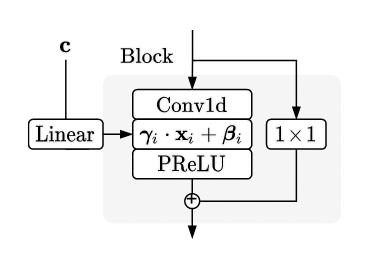

The network is composed of `n_layers` TCN blocks (pictured above).  There is a FiLM (feature-wise linear modulation, a common technique for conditioning/controlling neural networks) layer inserted in each of these blocks. Read more about FiLM [here](https://distill.pub/2018/feature-wise-transformations/). The cond vector $c$ can modulate the intermediate representation of these networks. While $c$ is set to 0 in this notebook, $c$ maybe set to the original parameter values of the modelled effect. See [microtcn](https://github.com/csteinmetz1/micro-tcn) for details.

## Model wrapper

Edit in information about your model in `get_model_name`, `get_model_authors`, etc.

The 4 neutone knobs are mapped to feature modulation depth (1) and modulation dimensions (3). The first controls the effect that the three later knobs have. The feature modulation dimensions can introduce unique effects to the output in an unexpected manner. Try them out in the plugin!




In [ ]:
class TCNModelWrapper(WaveformToWaveformBase):
    def get_model_name(self) -> str:
        return "tcn.SOMETHING"

    def get_model_authors(self) -> List[str]:
        return ["YOUR NAME HERE"]

    def get_model_short_description(self) -> str:
        return "Neural SOMETHING effect"

    def get_model_long_description(self) -> str:
        return "Neural SOMETHING effect through Time Convolutional Neural Network"

    def get_technical_description(self) -> str:
        return "Random SOMETHING effect through Temporal 1D-convolution layers. Based on the idea proposed by Steinmetz et al."

    def get_tags(self) -> List[str]:
        return ["type of effect"]

    def get_model_version(self) -> str:
        return "1.0.0"

    def is_experimental(self) -> bool:
        return False

    def get_technical_links(self) -> Dict[str, str]:
        return {
            "Paper": "https://arxiv.org/abs/2112.02926",
            "Code": "https://github.com/csteinmetz1/steerable-nafx"
        }

    def get_citation(self) -> str:
        return "Steinmetz, C. J., & Reiss, J. D. (2021). Steerable discovery of neural audio effects. at 5th Workshop on Creativity and Design at NeurIPS."

    def get_neutone_parameters(self) -> List[NeutoneParameter]:
        return [NeutoneParameter("depth", "Modulation Depth", 0.5),
                NeutoneParameter("P1", "Feature modulation 1", 0.0),
                NeutoneParameter("P2", "Feature modulation 2", 0.0),
                NeutoneParameter("P3", "Feature modulation 3", 0.0)
                ]

    @torch.jit.export
    def is_input_mono(self) -> bool:
        return False

    @torch.jit.export
    def is_output_mono(self) -> bool:
        return False

    @torch.jit.export
    def get_native_sample_rates(self) -> List[int]:
        return []  # Supports all sample rates

    @torch.jit.export
    def get_native_buffer_sizes(self) -> List[int]:
        return []  # Supports all buffer sizes

    def do_forward_pass(self, x: Tensor, params: Dict[str, Tensor]) -> Tensor:
        # conditioning for FiLM layer
        p1 = params["P1"]
        p2 = params["P2"]
        p3 = params["P3"]
        depth = params["depth"]
        cond = torch.stack([p1, p2, p3], dim=1) * depth
        cond = cond.expand(x.shape[0], 3)
        x = x.unsqueeze(1)
        x = self.model(x, cond)
        x = x.squeeze(1)
        return x

In [ ]:
#@title Save neutone model
from pathlib import Path
model.eval()
model = torch.jit.script(model.to('cpu'))
model(torch.zeros(2,1,4096), torch.zeros(2, 3))
wrapped = TCNModelWrapper(model)
neutone_save_dir = '/content/drive/MyDrive/neutonemodel/' #@param {type:"string"}
save_neutone_model(
        wrapped, Path(neutone_save_dir), freeze=False, dump_samples=True, submission=True
)

## Use model in neutone!

Congrats! You can now download the .nm file from Google Drive (under `{neutone_save_dir}`) and load it in neutone (via the "load your own" button at the top of the model selection screen)